In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.metrics import f1_score, precision_recall_curve, precision_score, roc_auc_score, roc_curve, recall_score, confusion_matrix, classification_report
from scipy import stats
from imblearn.over_sampling import SMOTE
import statsmodels.api as sm
import time

sns.set(style="darkgrid")

plt.rcParams['xtick.major.pad']='9'
plt.rcParams['ytick.major.pad']='9'

%matplotlib inline

In [2]:
path = '/Users/seed/Desktop/git/Classification/bank_additiional_05112020/Data/bank-additional-full.csv'

data = pd.read_csv(path, sep=';')

display(data.head(3))

print('Instances = {}\n\nFeatures = {}'.format(data.shape[0], data.shape[1]))

FileNotFoundError: [Errno 2] File /Users/seed/Desktop/git/Classification/bank_additiional_05112020/Data/bank-additional-full.csv does not exist: '/Users/seed/Desktop/git/Classification/bank_additiional_05112020/Data/bank-additional-full.csv'

In [120]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [121]:
data.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

Dataset info:

It is a dataset that describing Portugal bank marketing campaigns results.
Conducted campaigns were based mostly on direct phone calls, offering bank client to place a term deposit.
If after all marking afforts client had agreed to place deposit - target variable marked 'yes', otherwise 'no'

Features info:

- age: the age of the target user (between 17 and 98 ages)
- job: type of job (divided in categories) of the target user (admin, blue-collar, technician, services, management, retired, entreprenour, self-employed, housemaid, unemployed, student, unknown)
- marital: civil status of the target user (married, single, divorced, unknown)
- education: education level of the target user (university.degree, high.school, basic.9y, professional.course, basic.4y, basic.6y, unknown, illiterate )
- default: if the target user has a credit in default (yes, no or unknow)
- housing: if the target user has a housing loan (yes, no or unknow)
- loan: if the target user has a personal loan (yes or no)
- contact: telephone means to contact the user (desktop telephone or movil telephone)
- month: month in wich was contacted the target user (March to December)
- day_of_week: weekday in wich was contacted the target user (Monday to Friday)
- duration: last contact duration, in seconds, with the target user (0 to 4918 seconds)
- campaign: number of contacts performed during this campaign and for this client (1 to 56)
- pdays: number of days that passed by after the client was last contacted from a previous campaign (0 to 999)
- previous: number of contacts performed before this campaign and for this client (0 to 7)
- poutcome: outcome of the previous marketing campaign (failure, nonexistent, success)
- emp.var.rate: employment variation rate - quarterly indicator (-3.4 to 1.4)
- cons.price.idx: consumer price index - monthly indicator (92.20 to 94.77)
- cons.conf.idx: consumer confidence index - monthly indicator (-50.80 to -26.90)
- euribor3m: euribor 3 month rate - daily indicator (0.63 to 5.04)
- nr.employed: number of employees - quarterly indicator (4963.60 to 5228.10)

Target:

- y: If the client has subscribed a term deposit (yes or no)

Let's see the values for each categorical column of the dataset

In [122]:
def uniques_val_col(df):
    for col in df:
        print(col,'-----------', data[col].unique(),'\n', sep='\n')

uniques_val_col(df=data.select_dtypes(include='object'))

job
-----------
['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']


marital
-----------
['married' 'single' 'divorced' 'unknown']


education
-----------
['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']


default
-----------
['no' 'unknown' 'yes']


housing
-----------
['no' 'yes' 'unknown']


loan
-----------
['no' 'yes' 'unknown']


contact
-----------
['telephone' 'cellular']


month
-----------
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']


day_of_week
-----------
['mon' 'tue' 'wed' 'thu' 'fri']


poutcome
-----------
['nonexistent' 'failure' 'success']


y
-----------
['no' 'yes']




There are two categorical columns that has many values: 'job' and 'education'. In jobs columns have sense that have many unique values because the professions described are very different between them and give for our model different information.

But in education column there are unique values that provide to the model  the same information so we are going to group them:

In [123]:
data = data.replace(['basic.4y', 'high.school', 'basic.6y', 'basic.9y'],['basic', 'basic', 'basic', 'basic'])

data.education.unique()

array(['basic', 'professional.course', 'unknown', 'university.degree',
       'illiterate'], dtype=object)

Looking for the outliers

We make a describe() in order to see the max, min and the quantiles for select features with high rate of variance to find the z-scores for them.

In [124]:
round(data.describe(), 2)

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00,41188.00,41188.00,41188.00,41188.00,41188.00,41188.00,41188.00,41188.00,41188.00
mean,40.02,258.29,2.57,962.48,0.17,0.08,93.58,-40.50,3.62,5167.04
std,10.42,259.28,2.77,186.91,0.49,1.57,0.58,4.63,1.73,72.25
min,17.00,0.00,1.00,0.00,0.00,-3.40,92.20,-50.80,0.63,4963.60
25%,32.00,102.00,1.00,999.00,0.00,-1.80,93.08,-42.70,1.34,5099.10
50%,38.00,180.00,2.00,999.00,0.00,1.10,93.75,-41.80,4.86,5191.00
75%,47.00,319.00,3.00,999.00,0.00,1.40,93.99,-36.40,4.96,5228.10
max,98.00,4918.00,56.00,999.00,7.00,1.40,94.77,-26.90,5.04,5228.10


The decribe method give us dispersions measures for numerical features. We are going to create a sub-set from the original with the numerical features with a high rate of variance in order to find the significative outliers. 

I think that we must take a sight to 'age', 'duration', 'campaign', 'previous' because the distance between their third and fourth quantil is significative and calculate the z-score for them.

In [125]:
"""data_var = data[['age', 'duration', 'campaign', 'previous']]

z = np.abs(stats.zscore(data_var))

z"""

"data_var = data[['age', 'duration', 'campaign', 'previous']]\n\nz = np.abs(stats.zscore(data_var))\n\nz"

The array from above tell us the the z-score from all the instances and features, so now if we fix a threshold for z-score, making a mask we could identify the position of outliers in the array.

In [126]:
"""np.where(z > 3)"""

'np.where(z > 3)'

the first array from above is the number of row for the outlier and the second for the columns and the second tell us the row.

In [127]:
"""cleaned = data_var[(z < np.absolute(3)).all(axis=1)]

cleaned"""

'cleaned = data_var[(z < np.absolute(3)).all(axis=1)]\n\ncleaned'

In [128]:
"""print(' data with outliers:    ', data_var.shape[0], '\n', 
     'data without outliers: ', cleaned.shape[0], '\n',
     'number of outliers:    ', data_var.shape[0] - cleaned.shape[0]
     )"""

"print(' data with outliers:    ', data_var.shape[0], '\n', \n     'data without outliers: ', cleaned.shape[0], '\n',\n     'number of outliers:    ', data_var.shape[0] - cleaned.shape[0]\n     )"

Now we are going to merge the data frame cleaned only for te numerical values, and merging it with the original by te indexes

In [129]:
"""data_cleaned = pd.merge(cleaned, data, left_index=True, right_index=True)

data_cleaned = data_cleaned.iloc[:,4:]"""

'data_cleaned = pd.merge(cleaned, data, left_index=True, right_index=True)\n\ndata_cleaned = data_cleaned.iloc[:,4:]'

In [130]:
"""data_cleaned.head()"""

'data_cleaned.head()'

In [131]:
"""data_cleaned.shape"""

'data_cleaned.shape'

In order to see what we are doing with nan values, let's check the correlations between the numerical features and the target and do some visualizations of the features:

Text(0, 0.5, 'Calls')

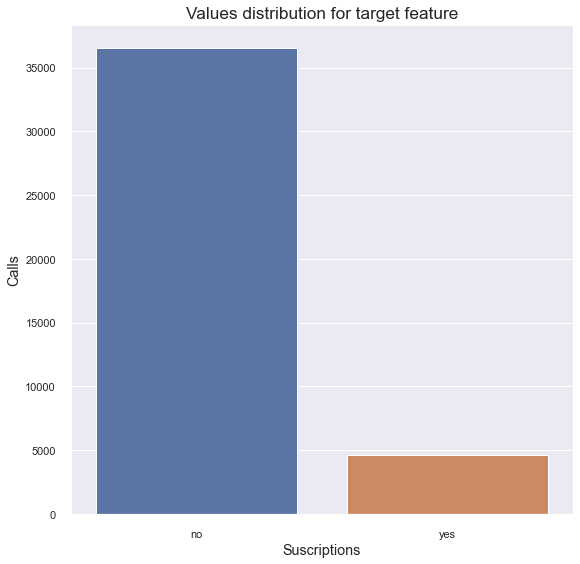

In [132]:
plt.figure(figsize=(9,9))
plt.title('Values distribution for target feature', size='xx-large')
sns.countplot(x='y', data=data)
plt.xlabel('Suscriptions', size='x-large')
plt.ylabel('Calls', size='x-large')

In [133]:
round(data.groupby(by='y').mean(), 2)

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
y,,,,,,,,,,
no,39.91,220.84,2.63,984.11,0.13,0.25,93.60,-40.59,3.81,5176.17
yes,40.91,553.19,2.05,792.04,0.49,-1.23,93.35,-39.79,2.12,5095.12


In [134]:
no = data.y.value_counts()[0]
yes = data.y.value_counts()[1]

pct_yes = round(yes/(no + yes)*100, 2)
pct_no = round(no/(no + yes)*100, 2)

print('Percentage of no subscription = {} %\nPercentage of subscription = {} %'.format(pct_no, pct_yes))

Percentage of no subscription = 88.73 %
Percentage of subscription = 11.27 %


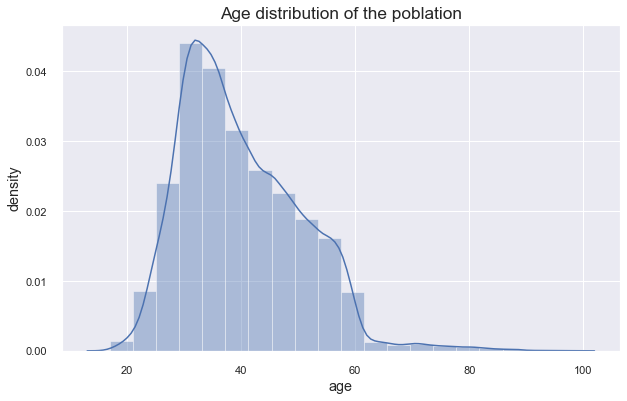

In [135]:
plt.figure(figsize=(10, 6))
plt.title("Age distribution of the poblation", size='xx-large')
plt.ylabel("density", size='x-large')
plt.xlabel("Age", size='x-large')
sns.distplot(a=data.age, bins=20, norm_hist=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fae18980350>,
      dtype=object)

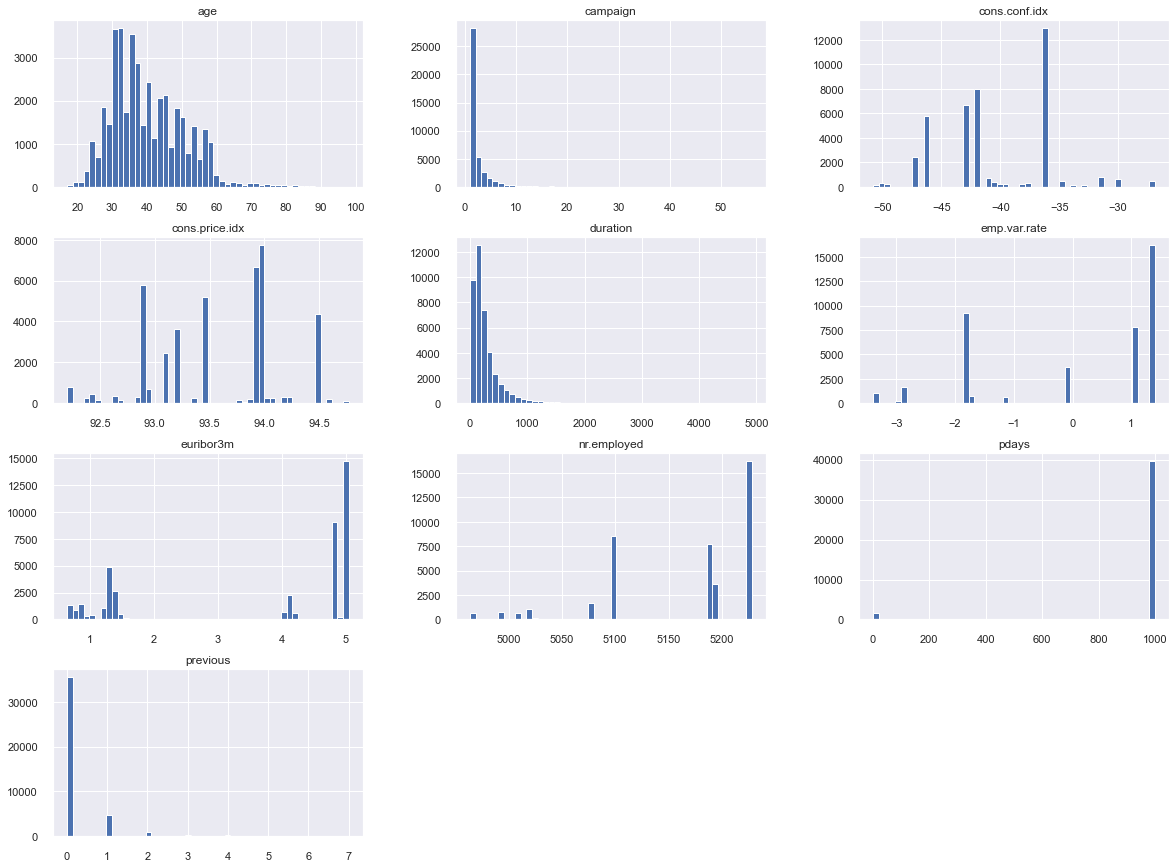

In [136]:
data.hist(bins=50, figsize=(20,15))

Exploring categorical values

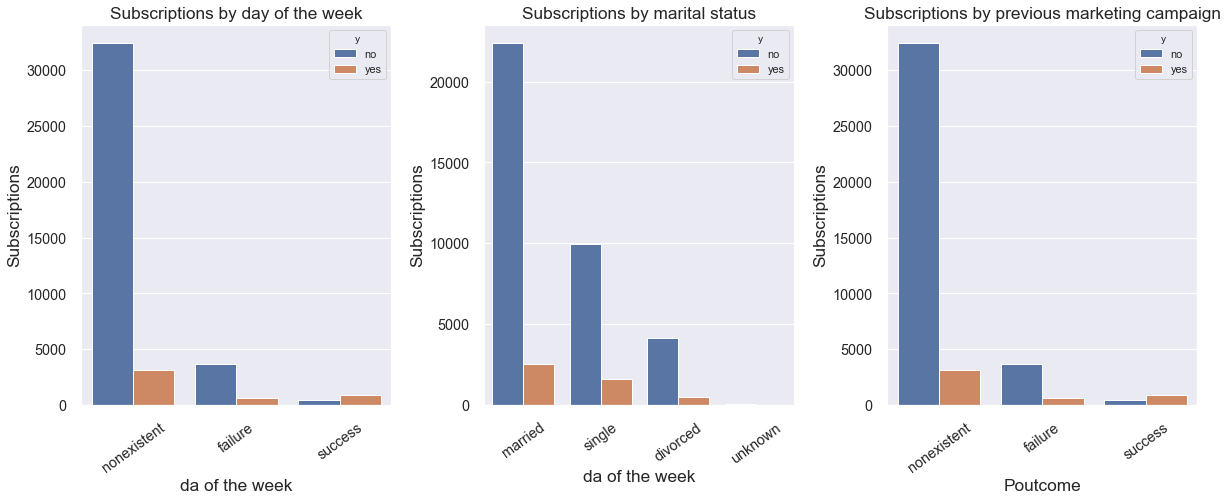

In [137]:
plt.figure(figsize=(20,7))
plt.subplots_adjust(wspace = 0.3)

plt.subplot(131)

sns.countplot(data=data , x='poutcome', hue='y')
plt.title('Subscriptions by day of the week', size='xx-large')
plt.xticks(rotation=36, size='x-large')
plt.xlabel('da of the week', size='xx-large')
plt.yticks(size='x-large')
plt.ylabel('Subscriptions', size='xx-large')

plt.subplot(132)

sns.countplot(data=data , x='marital', hue='y')
plt.title('Subscriptions by marital status', size='xx-large')
plt.xticks(rotation=36, size='x-large')
plt.xlabel('da of the week', size='xx-large')
plt.yticks(size='x-large')
plt.ylabel('Subscriptions', size='xx-large')

plt.subplot(133)

sns.countplot(data=data , x='poutcome', hue='y')
plt.title('Subscriptions by previous marketing campaign', size='xx-large')
plt.xticks(rotation=36, size='x-large')
plt.xlabel('Poutcome', size='xx-large')
plt.yticks(size='x-large')
plt.ylabel('Subscriptions', size='xx-large')

plt.show()

Text(0, 0.5, 'Subscriptions')

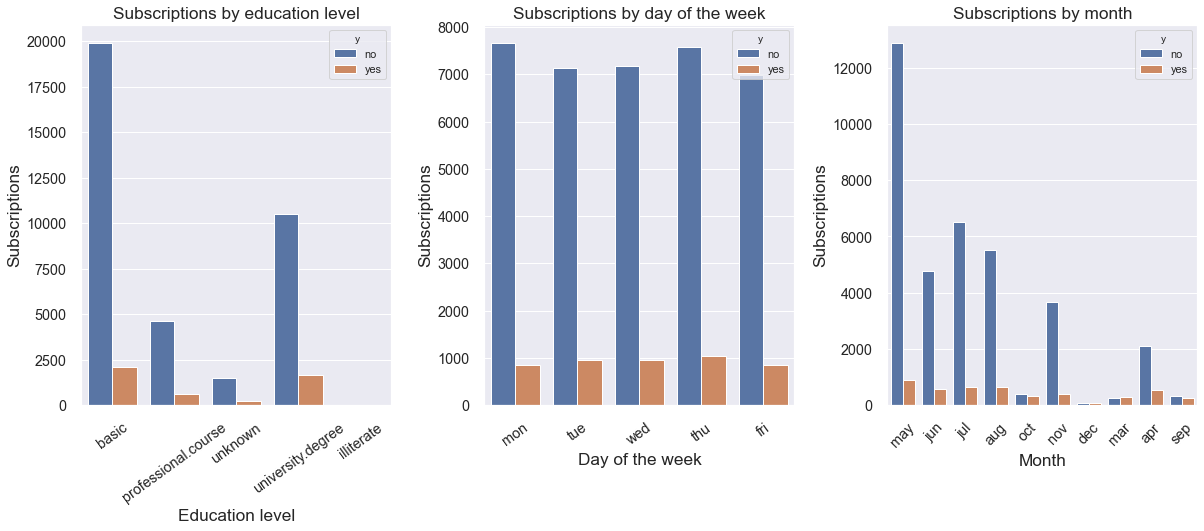

In [138]:
plt.figure(figsize=(20,7))
plt.subplots_adjust(wspace = 0.3)

plt.subplot(131)

sns.countplot(data=data , x='education', hue='y')
plt.title('Subscriptions by education level', size='xx-large')
plt.xticks(rotation=36, size='x-large')
plt.xlabel('Education level', size='xx-large')
plt.yticks(size='x-large')
plt.ylabel('Subscriptions', size='xx-large')

plt.subplot(132)

sns.countplot(data=data , x='day_of_week', hue='y')
plt.title('Subscriptions by day of the week', size='xx-large')
plt.xticks(rotation=36, size='x-large')
plt.xlabel('Day of the week', size='xx-large')
plt.yticks(size='x-large')
plt.ylabel('Subscriptions', size='xx-large')

plt.subplot(133)

sns.countplot(data=data , x='month', hue='y')
plt.title('Subscriptions by month', size='xx-large')
plt.xticks(rotation=46, size='x-large')
plt.xlabel('Month', size='xx-large')
plt.yticks(size='x-large')
plt.ylabel('Subscriptions', size='xx-large')

As we can see the distribution of the target class is clearly unbalanced, so to fix this we are going to use the SMOTE oversampling technique to get a balanced data.

In [139]:
data.corr().style.background_gradient(cmap='PuBu')

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
age,1.000000,-0.000866,0.004594,-0.034369,0.024365,-0.000371,0.000857,0.129372,0.010767,-0.017725
duration,-0.000866,1.000000,-0.071699,-0.047577,0.020640,-0.027968,0.005312,-0.008173,-0.032897,-0.044703
campaign,0.004594,-0.071699,1.000000,0.052584,-0.079141,0.150754,0.127836,-0.013733,0.135133,0.144095
pdays,-0.034369,-0.047577,0.052584,1.000000,-0.587514,0.271004,0.078889,-0.091342,0.296899,0.372605
previous,0.024365,0.020640,-0.079141,-0.587514,1.000000,-0.420489,-0.203130,-0.050936,-0.454494,-0.501333
emp.var.rate,-0.000371,-0.027968,0.150754,0.271004,-0.420489,1.000000,0.775334,0.196041,0.972245,0.906970
cons.price.idx,0.000857,0.005312,0.127836,0.078889,-0.203130,0.775334,1.000000,0.058986,0.688230,0.522034
cons.conf.idx,0.129372,-0.008173,-0.013733,-0.091342,-0.050936,0.196041,0.058986,1.000000,0.277686,0.100513
euribor3m,0.010767,-0.032897,0.135133,0.296899,-0.454494,0.972245,0.688230,0.277686,1.000000,0.945154
nr.employed,-0.017725,-0.044703,0.144095,0.372605,-0.501333,0.906970,0.522034,0.100513,0.945154,1.000000


FEATURE ENGINEERING

In [140]:
print(' numerical data --> ', data.select_dtypes(['float', 'int']).columns, '\n'*2, 'categical data --> ', data.select_dtypes(['object']).columns)

 numerical data -->  Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'],
      dtype='object') 

 categical data -->  Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome', 'y'],
      dtype='object')


In [141]:
train_data, test_data = train_test_split(data, test_size=0.2)

class ColumnsSelector(BaseEstimator, TransformerMixin):
  
  def __init__(self, type):
    self.type = type
  
  def fit(self, X, y=None):
    return self
  
  def transform(self,X):
    return X.select_dtypes(include=[self.type])

class CategoricalImputer(BaseEstimator, TransformerMixin):
  
  def __init__(self, columns = None, strategy='most_frequent'):
    self.columns = columns
    self.strategy = strategy
    
    
  def fit(self,X, y=None):
    if self.columns is None:
      self.columns = X.columns
    
    if self.strategy is 'most_frequent':
      self.fill = {column: X[column].value_counts().index[0] for column in self.columns}
    else:
      self.fill ={column: '0' for column in self.columns}
      
    return self
      
  def transform(self,X):
    X_copy = X.copy()
    for column in self.columns:
      X_copy[column] = X_copy[column].fillna(self.fill[column])
    return X_copy

class CategoricalEncoder(BaseEstimator, TransformerMixin):
  
  def __init__(self, dropFirst=True):
    self.categories=dict()
    self.dropFirst=dropFirst
    
  def fit(self, X, y=None):
    join_df = pd.concat([train_data, test_data])
    join_df = join_df.select_dtypes(include=['object'])
    for column in join_df.columns:
      self.categories[column] = join_df[column].value_counts().index.tolist()
    return self
    
  def transform(self, X):
    X_copy = X.copy()
    X_copy = X_copy.select_dtypes(include=['object'])
    
    return pd.get_dummies(X_copy, drop_first=self.dropFirst)

num_pipeline = Pipeline(steps=[
    ("num_attr_selector", ColumnsSelector(type='int')),
    ("scaler", StandardScaler())
                      ])

cat_pipeline = Pipeline(steps=[
    ("cat_attr_selector", ColumnsSelector(type='object')),
    ("cat_imputer", CategoricalImputer(columns=['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome', 'y'])),
    ("encoder", CategoricalEncoder(dropFirst=True))
                      ])

full_pipeline = FeatureUnion([("num_pipe", num_pipeline), ("cat_pipeline", cat_pipeline)])

data_processed = full_pipeline.fit_transform(data)

print("Shape = {} \nNew dimmensions = {}".format(data_processed.shape, (data_processed.shape[1] - data.shape[1])))

Shape = (41188, 46) 
New dimmensions = 25


Oversampling with SMOTE

In [142]:
X = data_processed[:,0:-1]
y = data_processed[:,-1]

os = SMOTE()
X, y = os.fit_resample(X, y)


In [143]:
no = 0
yes = 0

for value in y:
    if value == 0:
        no += 1
    else:
        yes += 1

print("Number of total instances = {}".format(yes+no))
print("Number of 'no' (suscription) class = {} (Proportion = {})".format(no, (no/(yes+no))))
print("Number of 'yes' (suscription) class = {} (Proportion = {})".format(yes, (yes/(yes+no))))

Number of total instances = 73096
Number of 'no' (suscription) class = 36548 (Proportion = 0.5)
Number of 'yes' (suscription) class = 36548 (Proportion = 0.5)


Now we have preprocesed the data and divided in the predictors (X) and the target (y). The main transformations of the data have been 

- The numerical values have been standarized by the StandardScaler class from sklearn.

## LOGISTIC REGRESSION

In [144]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

lr = LogisticRegression().fit(X_train, y_train)

predictions = lr.predict(X_test)

In [145]:
lr.score(X_test, y_test)

0.8517488257558484

Let's see how the model generalizes through the cross validation score:

In [146]:
cross = cross_val_score(lr, X_train, y_train, cv=5)

def mean_crossval_kfolds(x):
    avg_score = 0
    for i in x:
        avg_score += i/len(x)

    print(' Averaged score: ', avg_score, '\n', 'k-folds scores: ', x)

mean_crossval_kfolds(x=cross)

 Averaged score:  0.8515058488402554 
 k-folds scores:  [0.85098691 0.85225718 0.84725887 0.85321997 0.85380631]


Let's search the best parameters with Randomizedsearch:

In [147]:
model_params = {
    'C' : [0, 0.5, 1],
    'l1_ratio': [0, 0.5, 1],
    'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

rand = RandomizedSearchCV(lr, param_distributions=model_params, return_train_score=True, n_iter=10, iid=True).fit(X_train, y_train)

print('Best parameters: ', rand.best_params_)
print('Best estimator: ', rand.best_estimator_)

Best parameters:  {'solver': 'newton-cg', 'l1_ratio': 1, 'C': 1}
Best estimator:  LogisticRegression(C=1, l1_ratio=1, solver='newton-cg')


let's see how imprive our model applying the best params suggested by RandomizedsearchCV

In [148]:
lr2 = LogisticRegression(C=0.5, l1_ratio=0, solver='lbfgs').fit(X_train, y_train)

predicts2 = lr2.predict(X_test)

lr2.score(X_test, y_test)

0.8517944274704728

In [149]:
print(classification_report(y_test, predicts2))

              precision    recall  f1-score   support

         0.0       0.85      0.86      0.85     11000
         1.0       0.86      0.84      0.85     10929

    accuracy                           0.85     21929
   macro avg       0.85      0.85      0.85     21929
weighted avg       0.85      0.85      0.85     21929



There isn't a reliable improve for the algorythm :-(

In [150]:
cm = confusion_matrix(y_test, predictions)

cm

array([[9449, 1551],
       [1700, 9229]])

In [151]:
print(' True Posituves:  ', cm[1,1],'\n',
      'True Negatives:  ', cm[0,0],'\n',
      'False Positives: ', cm[0,1],'\n',
      'False Negatives: ', cm[1,1])

 True Posituves:   9229 
 True Negatives:   9449 
 False Positives:  1551 
 False Negatives:  9229


In [152]:
y_scores = cross_val_predict(lr2, X_train, y_train)

fpr, tpr, thresholds = roc_curve(y_train, y_scores)

precission = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print(' precission score:    ', precission,'\n',
      'recall score:        ', recall,'\n', 
      'f1 score:            ', f1,'\n',
      'True positive rate:  ', tpr,'\n', 
      'False positive rate: ', fpr,'\n',
      'Threshold:           ', thresholds)

 precission score:     0.8561224489795919 
 recall score:         0.8444505444230945 
 f1 score:             0.8502464415680132 
 True positive rate:   [0.         0.84640306 1.        ] 
 False positive rate:  [0.         0.14329889 1.        ] 
 Threshold:            [2. 1. 0.]


Our classifier is balanced more to precission than recall, and for the values we can confirm the precission-recall trade off.

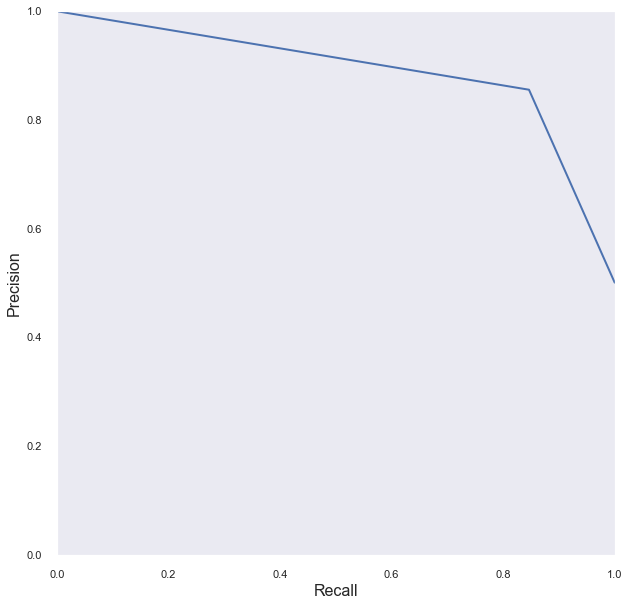

In [153]:
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.grid(axis='both')
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(10, 10))
plot_precision_vs_recall(precisions=precisions, recalls=recalls)

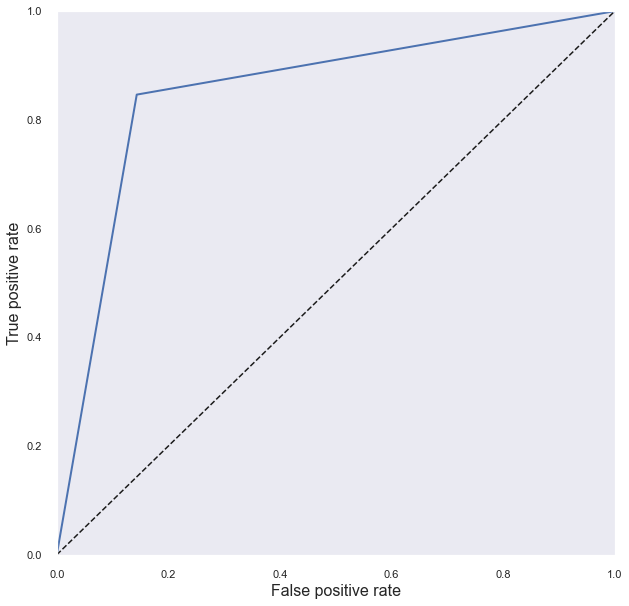

In [154]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(10,10))
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.grid(axis='both')
    plt.ylabel('True positive rate', fontsize=16)
    plt.xlabel('False positive rate', fontsize=16)

plot_roc_curve(fpr=fpr, tpr=tpr)

In [160]:
import statsmodels.api as sm
logit_model = sm.Logit(y,X)
result = logit_model.fit()

result.summary2()

         Current function value: 0.365391
         Iterations: 35


LinAlgError: Singular matrix

## Stochastic Gradient descent classifier

When the model is trained, the way of doing predictions is very similar than the logistic regression or the other classifiers of the linear model, but with the stochastic Gradien descent the algorythm only takes one instance (The batch gradient descent uses all the instances) for claculate the gradient vector. 

We believe than we are going to have worst score (This model produces good-reasonable solutions, not optimum solutions) but let's see how many score loose the model for this small-medium dataset

In [155]:
sgd = SGDClassifier()

model_params = {
    'shuffle': [True,False],
    'loss': ['hinge', 'modified_huber', 'squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
    'penalty': ['l2', 'l1', 'elasticnet']
}

rand_sgd = RandomizedSearchCV(sgd, param_distributions=model_params, return_train_score=True, n_iter=10, iid=True).fit(X_train, y_train)

print('Best parameters: ', rand_sgd.best_params_)
print('Best estimator: ', rand_sgd.best_estimator_)

Best parameters:  {'shuffle': False, 'penalty': 'l1', 'loss': 'hinge'}
Best estimator:  SGDClassifier(penalty='l1', shuffle=False)


In [156]:
start = time.time()

sgd = SGDClassifier(shuffle=False, penalty='l1', loss='hinge').fit(X_train, y_train)

sgd_predictions = sgd.predict(X_test)

elapsed_time = time.time() - start

print(' SGD Classifier score: ', sgd.score(X_test, y_test), '\n', 'Training time: ', elapsed_time)

 SGD Classifier score:  0.8579962606594008 
 Training time:  0.3024458885192871


In [157]:
cross_sgd = cross_val_score(sgd, X_train, y_train, cv=5)

mean_crossval_kfolds(x=cross_sgd)

 Averaged score:  0.8464240877604579 
 k-folds scores:  [0.85870627 0.85284346 0.85116779 0.85556533 0.81383758]


No handles with labels found to put in legend.


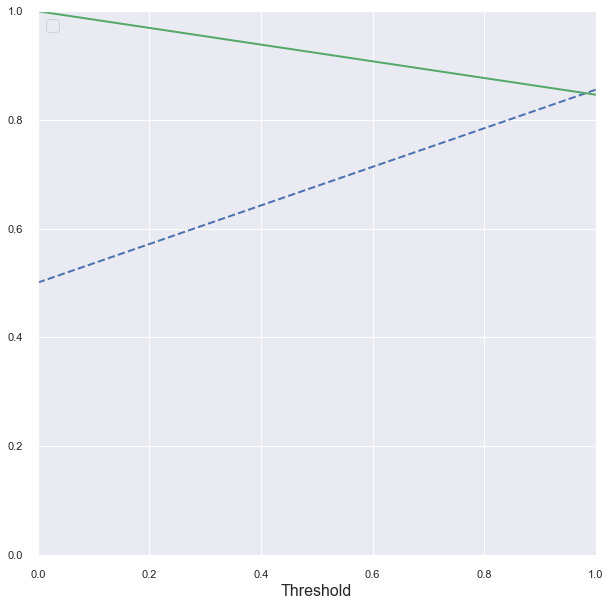

In [158]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(10,10))
    plt.axis([0, 1, 0, 1])
    plt.ylim([0, 1])
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision', linewidth=2)
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall', linewidth=2)

plot_precision_recall_vs_threshold(precisions=precisions, recalls=recalls, thresholds=thresholds)

The dataset is small size so is not necessary reduce the computing time to get the train of the model, so performing stochastic gradient descent does't fit with this dataset because performs worst than batch gradient descent.